<a href="https://colab.research.google.com/github/bestmeebo/Roc/blob/main/%E2%80%9CFrog_and_tail_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install anndata
!pip install scanpy

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.io import mmread

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [3]:
import anndata as ad
#extract_dir = "/content/drive/Shareddrive/STAT5243/Projects/Part 1/Datasets/"
adata = ad.read_h5ad('/content/drive/MyDrive/TA/Frogtail_files/cleaned_processed_frogtail.h5ad') # ad.read_h5ad()

/usr/local/lib/python3.11/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.X.toarray()[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
#adata.X.todense()

In [5]:
adata.obs.head() #every line is a cell

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3


In [6]:
adata.var.head()#check the gene  orginal data,every line is a gene

""
Xelaev18000001m.g
Xelaev18000003m.g
Xelaev18000004m.g
Xelaev18000005m.g
tm6sf2.1


In [7]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

## Processing data

In [8]:
adata.layers["counts"] = adata.X.copy()
#复制原始数据到 adata.layers["counts"]，以防止后续归一化或转换数据时丢失原始表达矩阵

In [9]:
sc.pp.normalize_total(adata)
# Logarithmize the data每个细胞的总 RNA 计数会被缩放到相同的数值范围
sc.pp.log1p(adata)#使数据更接近正态分布

In [10]:
sc.pp.filter_genes(adata, min_cells=3)#去除在少于 3 个细胞中表达的基因（低表达基因）。
sc.pp.filter_cells(adata, min_genes=200)#去除测到少于 200 个基因的细胞（低质量细胞）。
sc.pp.highly_variable_genes(adata, n_top_genes=2300)#挑选变异性最高的 2300 个基因，大部分基因的表达是不变的（或者只是噪音），所以只保留高变异基因可以减少计算复杂度，并提升模型效果。

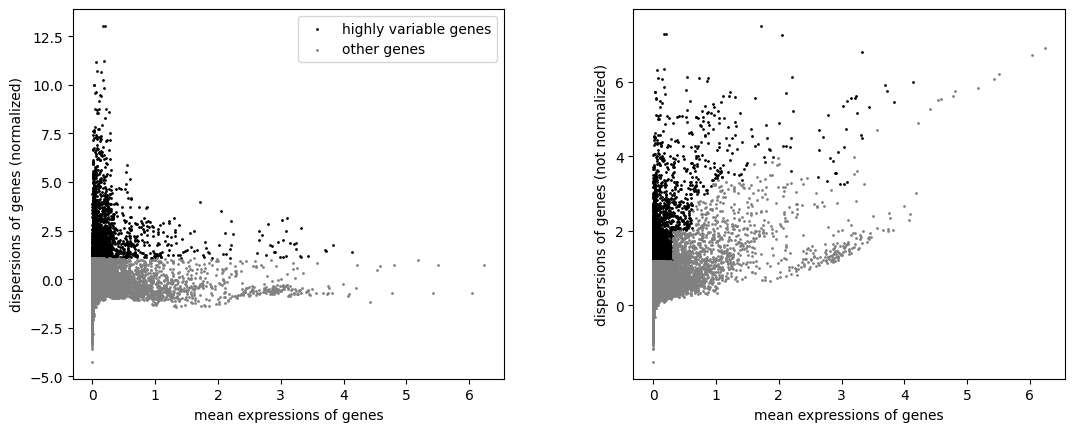

In [11]:
sc.pl.highly_variable_genes(adata)#黑色点（highly variable genes）在 mean expression vs. dispersion 图中更分散，说明它们的变化较大，适合用于聚类。

In [12]:
adata.obs['cluster'].unique()

['Erythrocyte 4', 'Myeloid 1', 'Beta ionocyte', 'Goblet cell', 'Erythrocyte 1', ..., 'Smooth muscle', 'Syndetome', 'Differentiating myocyte', 'Oligodendrocyte', 'Lymphoid endothelial cells']
Length: 46
Categories (46, object): ['Alpha ionocyte', 'Anterior notochord', 'Beta ionocyte', 'Dermomyotome', ...,
                          'Syndetome', 'Vascular endothelial cell', 'Vulnerable Motor Neuron',
                          'laminin-rich epidermis']

In [23]:
adata.obs["cluster"].value_counts()

,count
cluster,
Erythrocyte 1,2761
Epidermis,1800
Goblet cell,1754
Erythrocyte 3,982
Erythrocyte 4,862
Sclerotome,752
Spinal cord progenitor,505
Myeloid 1,475
Myotome,303


In [15]:
print(adata.var.columns)  # 查看有哪些可用的列

Index(['n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm'],
      dtype='object')


In [34]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_umap)


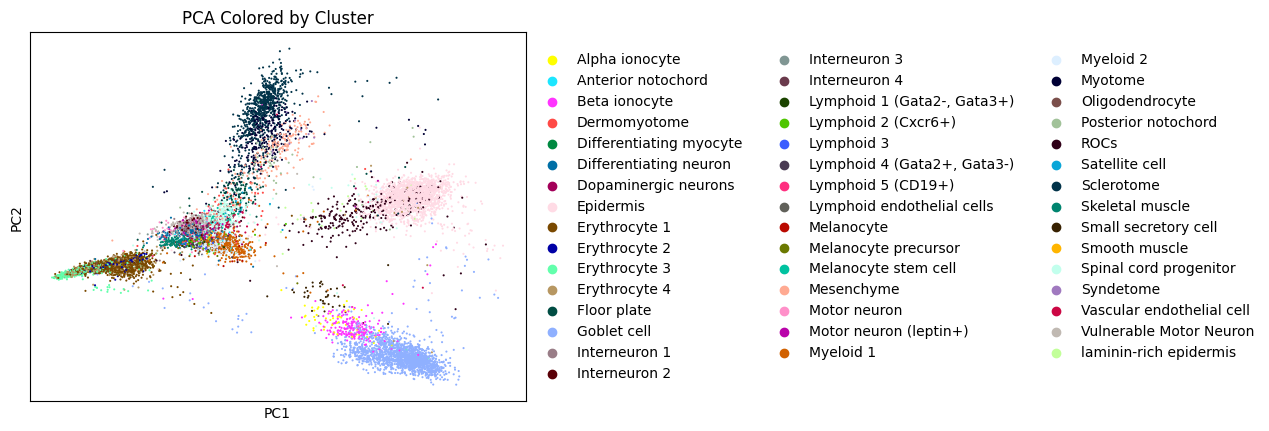

In [31]:
sc.pl.pca(adata, color="cluster", title="PCA Colored by Cluster")

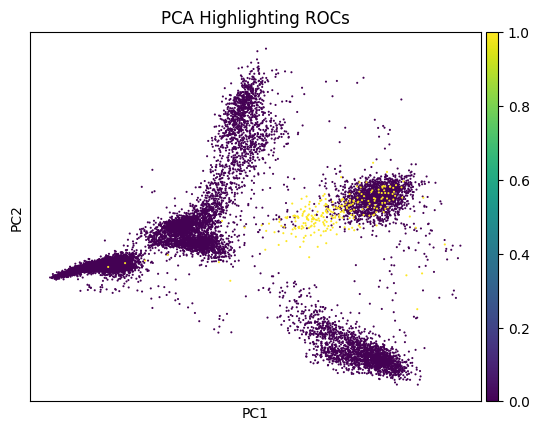

In [32]:
adata.obs["ROCs_Highlight"] = (adata.obs["cluster"] == "ROCs").astype(int)
sc.pl.pca(adata, color="ROCs_Highlight", title="PCA Highlighting ROCs")

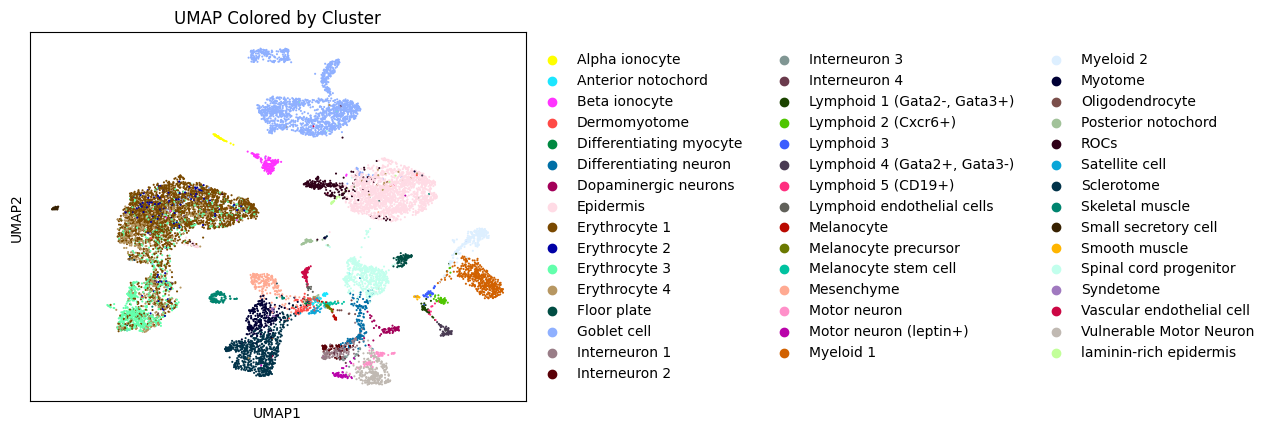

In [33]:
sc.pl.umap(adata, color="cluster", title="UMAP Colored by Cluster")

In [40]:
!pip install python-igraph louvain leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00


In [41]:
import scanpy as sc

# 计算邻接图（基于 PCA 降维后的数据）
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, n_pcs=30)

# 运行 Louvain 聚类
sc.tl.louvain(adata, resolution=0.5)

# 运行 Leiden 聚类
sc.tl.leiden(adata, resolution=0.5)

# 查看聚类结果存储在哪
print(adata.obs['louvain'].unique())
print(adata.obs['leiden'].unique())

<ipython-input-41-7ac7e455244c>:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


['5', '8', '11', '0', '2', ..., '14', '16', '15', '4', '9']
Length: 17
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']
['2', '10', '12', '0', '8', ..., '7', '23', '6', '16', '17']
Length: 26
Categories (26, object): ['0', '1', '2', '3', ..., '22', '23', '24', '25']


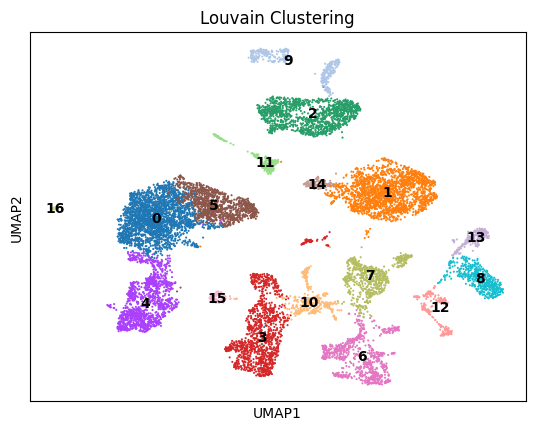

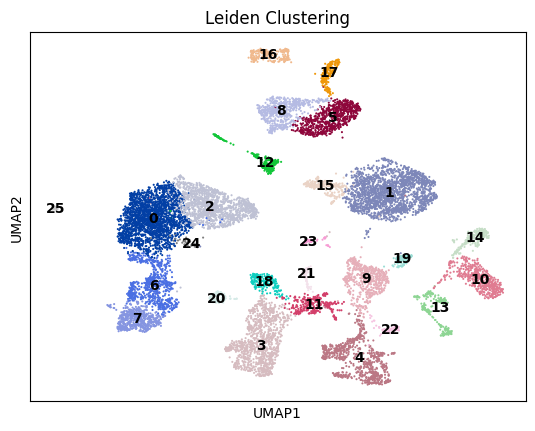

In [42]:
import matplotlib.pyplot as plt

# UMAP 可视化 Louvain 结果
sc.pl.umap(adata, color='louvain', title="Louvain Clustering", legend_loc="on data")

# UMAP 可视化 Leiden 结果
sc.pl.umap(adata, color='leiden', title="Leiden Clustering", legend_loc="on data")

In [43]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

# 计算 Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(adata.obs['louvain'], adata.obs['leiden'])
print(f"ARI score between Louvain and Leiden: {ari_score:.4f}")

# 计算 Silhouette Score
silhouette = silhouette_score(adata.obsm['X_pca'], adata.obs['louvain'].astype(int))
print(f"Silhouette Score for Louvain: {silhouette:.4f}")

silhouette_leiden = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden'].astype(int))
print(f"Silhouette Score for Leiden: {silhouette_leiden:.4f}")

ARI score between Louvain and Leiden: 0.8363
Silhouette Score for Louvain: 0.3295
Silhouette Score for Leiden: 0.3145


In [45]:
adata.obs.loc[adata.obs["cluster"] == "ROCs", ["louvain", "leiden"]].value_counts()


louvain  leiden
14       15        138
1        15         62
         1          44
0        24          3
5        2           2
0        0           1
         12          1
2        5           1
3        23          1
10       21          1
Name: count, dtype: int64

In [64]:
sc.tl.rank_genes_groups(adata, groupby="louvain", method="logreg")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
sc.pp.scale(adata)
sc.tl.rank_genes_groups(adata, groupby="louvain", method="logreg", max_iter=5000)

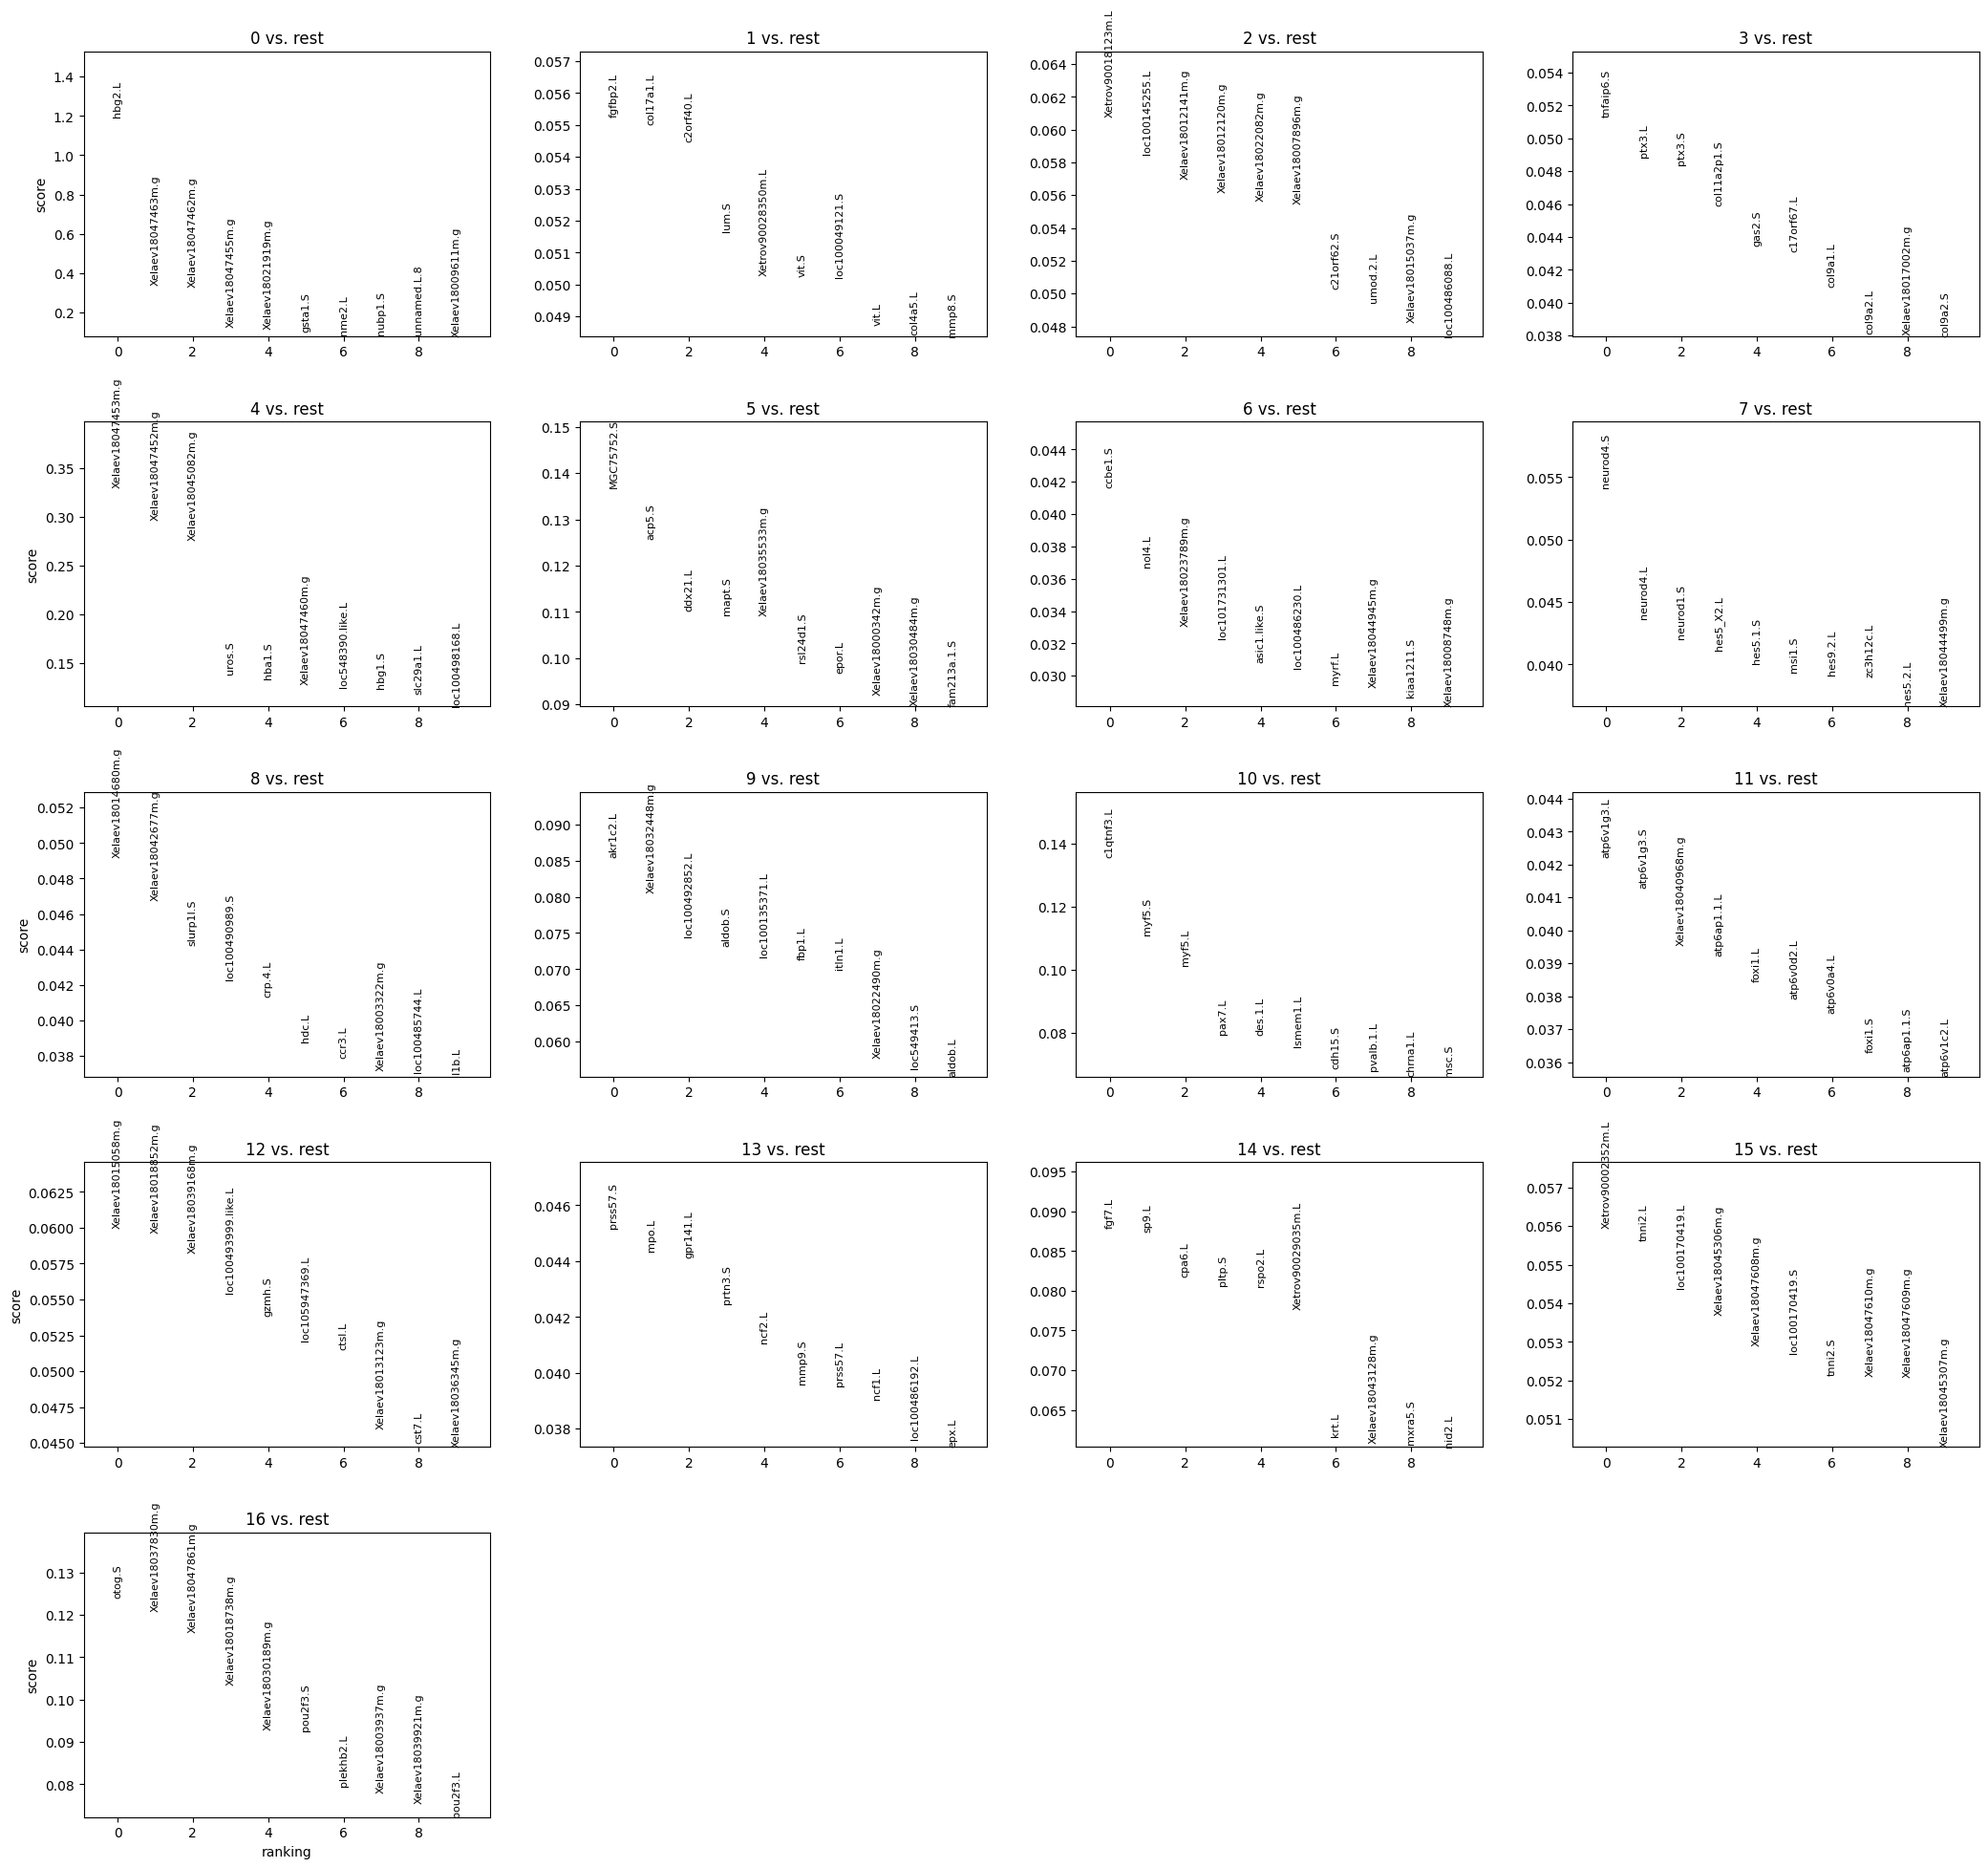

In [66]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [ ]:
import scanpy as sc

# 计算 marker 基因 (Wilcoxon 方法)
sc.tl.rank_genes_groups(adata, groupby="louvain", method="wilcoxon")

# 获取 Louvain 聚类中 ROCs (Cluster 14) 的 Top 10 marker 基因
wilcoxon_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print("Wilcoxon method - Top 10 markers:")
print(wilcoxon_markers)

In [ ]:
# 计算 marker 基因 (Logistic Regression)
sc.tl.rank_genes_groups(adata, groupby="louvain", method="logreg")

# 获取 Logistic Regression 计算出的 Top 10 marker 基因
logreg_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print("Logistic Regression method - Top 10 markers:")
print(logreg_markers)

In [ ]:
# 获取两种方法计算出的 marker 基因集合
wilcoxon_set = set(wilcoxon_markers.iloc[:, 0])  # 取第一列的基因名
logreg_set = set(logreg_markers.iloc[:, 0])

# 交集：两种方法都选出的 marker 基因
common_genes = wilcoxon_set.intersection(logreg_set)
print("Common genes in Wilcoxon & Logistic Regression:", common_genes)

# 读取 paper 标记基因列表
table3_genes = {"wnt5a", "egfl6", "rspo2", "fgf7", "tp73", "dlx2", "nid2", "bmp5", "sema3f"}  # 你可以替换为 Excel 读取的方式

# 计算和 Table S3 的交集
wilcoxon_matches = wilcoxon_set.intersection(table3_genes)
logreg_matches = logreg_set.intersection(table3_genes)

print("Wilcoxon method - Markers found in Table S3:", wilcoxon_matches)
print("Logistic Regression method - Markers found in Table S3:", logreg_matches)
# 论文提供的 ROC 细胞标志性基因
roc_reference_genes = {"Lef1", "Tp63", "Bmp2", "Wnt3a", "Dlx5", "Fgf8"}

# 计算与 Wilcoxon 结果的交集
wilcoxon_matches = wilcoxon_set.intersection(roc_reference_genes)
print("Wilcoxon 方法 - 论文已知 ROC 标志基因交集:", wilcoxon_matches)

# 计算与 Logistic Regression 结果的交集
logreg_matches = logreg_set.intersection(roc_reference_genes)
print("Logistic Regression 方法 - 论文已知 ROC 标志基因交集:", logreg_matches)

# 找到 Wilcoxon 和 Logistic Regression 的交集
common_genes = wilcoxon_set.intersection(logreg_set)
print("两种方法都选出的 marker 基因:", common_genes)

In [60]:
import pandas as pd

# 指定文件路径
file_path = "/content/drive/MyDrive/TA/Frogtail_files/tables3.xlsx"

# 读取 Excel 文件
xls = pd.ExcelFile(file_path)

# 获取所有 sheet 名称
sheet_names = xls.sheet_names
print("所有 sheet 名称:", sheet_names)

所有 sheet 名称: ['S-phase genes', 'G2M genes', 'FGF ligands', 'WNT ligands', 'BMP ligands', 'DELTA ligands', 'TGFß ligands', 'FGF receptors', 'WNT receptors', 'BMP receptors', 'NOTCH receptors', 'TGFß receptors', 'ROC markers']


In [62]:
# 读取所有 sheet 到字典中
gene_sets = {sheet: set(pd.read_excel(xls, sheet).iloc[:, 0].dropna().astype(str)) for sheet in sheet_names}

# 你的 ROCs 相关基因
roc_genes = {
    "col1a1.S", "apoc1-like.L", "Loc100496548", "mdk.L", "id3.S",
    "lamas.L", "fras1.L", "col14a1.L", "id3.L", "bambi.L",
    "ferm2.1.L", "egfl6.S", "hm1.S", "azn2.S", "msx2.L",
    "plk2.S", "my19.S", "mmp3.L", "mmp3.S", "camkd8.L", "mdk.S"
}

# 计算交集
intersections = {sheet: roc_genes.intersection(gene_sets[sheet]) for sheet in sheet_names}

# 打印结果（仅显示有交集的）
for sheet, genes in intersections.items():
    if genes:
        print(f"{sheet} 交集: {genes}")

In [ ]:
# 读取所有 sheet 到字典中
gene_sets = {sheet: set(pd.read_excel(xls, sheet).iloc[:, 0].dropna().astype(str)) for sheet in sheet_names}